# Stack Overflow: Tag Prediction



## 1.   Business Problem

**Description**

Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.

Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.

**Problem Statement**

Suggest the tags based on the content that was there in the question posted on Stackoverflow.




### LOAD REQUIRED LIBRARIES

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

### CONNECT TO GOOGLE COLAB

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### LOAD THE DATA FROM CSV FILE TO TRAIN.DB

In [ ]:
if not os.path.isfile('train.db'):
  start = datetime.now()
  disk_engine = create_engine('sqlite:///train.db')
  start=dt.datetime.now()
  chunksize=180000
  j=0
  index_start=1
  for df in pd.read_csv('/content/drive/My Drive/Colab Notebooks/StackOverflow Tag Predictor/Train.csv',names=['Id', 'Title', 'Body', 'Tags'],chunksize=chunksize, iterator=True, encoding='utf-8'):
    df.index +=index_start
    j+=1    
    df.to_sql('data', disk_engine, if_exists='append')
    index_start = df.index[-1] + 1
  print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:04:30.307245


### COUNT THE TOTAL NO OF ROWS

In [ ]:
if os.path.isfile('train.db'):
  start = datetime.now()
  con=sqlite3.connect('train.db')
  num_rows = pd.read_sql_query("""SELECT count(*) FROM data""",con)
  print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
  con.close()
  print("Time taken to count the number of rows :", datetime.now() - start)
else :
  print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:14.149502


### CHECK FOR DUPLICATES

In [ ]:
if os.path.isfile('train.db'):
  start = datetime.now()
  con=sqlite3.connect('train.db')
  df_no_duplicate=pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
  con.close()
  print("Time taken to run this cell :", datetime.now() - start)
else:
  print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:05:11.238108


In [ ]:
df_no_duplicate.head()

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [ ]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_duplicate.shape[0], "(",(1-((df_no_duplicate.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [ ]:
df_no_duplicate.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [ ]:
df_no_duplicate["Tags"].head()

0                                  c++ c
1            c# silverlight data-binding
2    c# silverlight data-binding columns
3                               jsp jstl
4                              java jdbc
Name: Tags, dtype: object

In [ ]:
start = datetime.now()
df_no_duplicate["tag_count"] = df_no_duplicate["Tags"].apply(lambda text: len(str(text).split()))
print("Time taken to run this cell :", datetime.now() - start)
df_no_duplicate.head()

Time taken to run this cell : 0:00:03.016791


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [ ]:
df_no_duplicate.tag_count.value_counts()

3    1206157
2    1111706
4     814996
1     568298
5     505158
Name: tag_count, dtype: int64

In [ ]:
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_duplicate, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [ ]:
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:01:54.541361


In [ ]:
tag_data.head()

,Tags
1,c# silverlight data-binding
2,c# silverlight data-binding columns
3,jsp jstl
4,java jdbc
5,facebook api facebook-php-sdk


In [ ]:
tag_data.loc[tag_data['Tags'].isnull(),'Tags'] = ''

### ANALYSIS OF TAGS --> COUNTVECTORIZER

In [ ]:
vectorizer=CountVectorizer(tokenizer = lambda x : str(x).split())

tag_dtm=vectorizer.fit_transform(tag_data['Tags'])

In [ ]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [ ]:
feature_tags=vectorizer.get_feature_names()

print("Some of the tags we have :", feature_tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


In [ ]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(feature_tags, freqs))

In [ ]:
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [ ]:
tag_df_sorted=tag_df.sort_values(['Counts'],ascending=False)

tag_counts=tag_df_sorted['Counts'].values

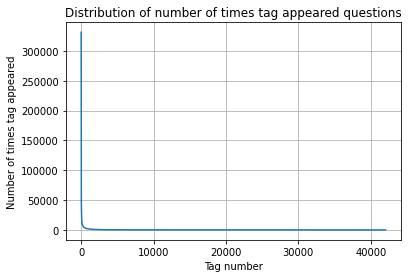

In [ ]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

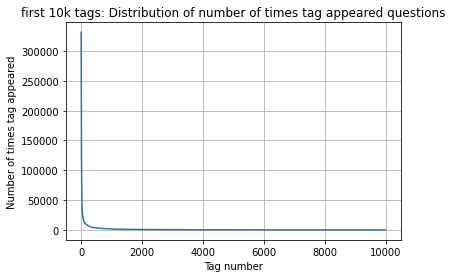

In [ ]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

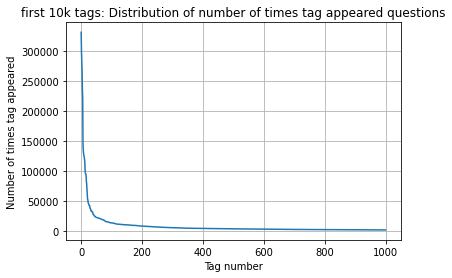

In [ ]:
plt.plot(tag_counts[0:1000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

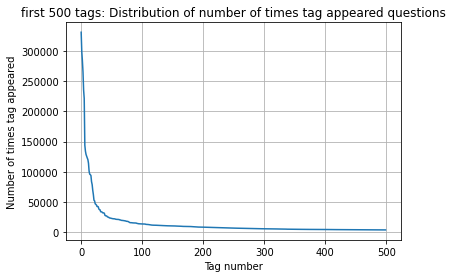

In [ ]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

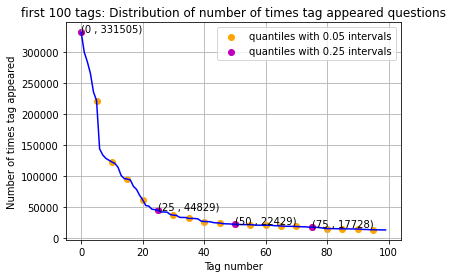

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [ ]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [ ]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


### Observations:



1.   There are total 153 tags which are used more than 10000 times.
2.   14 tags are used more than 100000 times.
3.   Most frequent tag (i.e. c#) is used 331505 times.
4.   Since some tags occur much more frequenctly than others 
5.   Micro-averaged.   F1-score is the appropriate metric for this probelm.

## TAGS PER QUESTION

In [ ]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()

tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


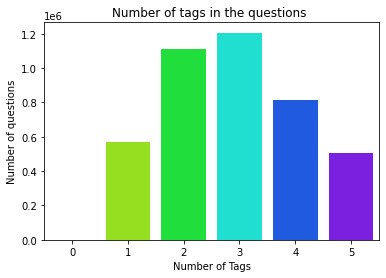

In [ ]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

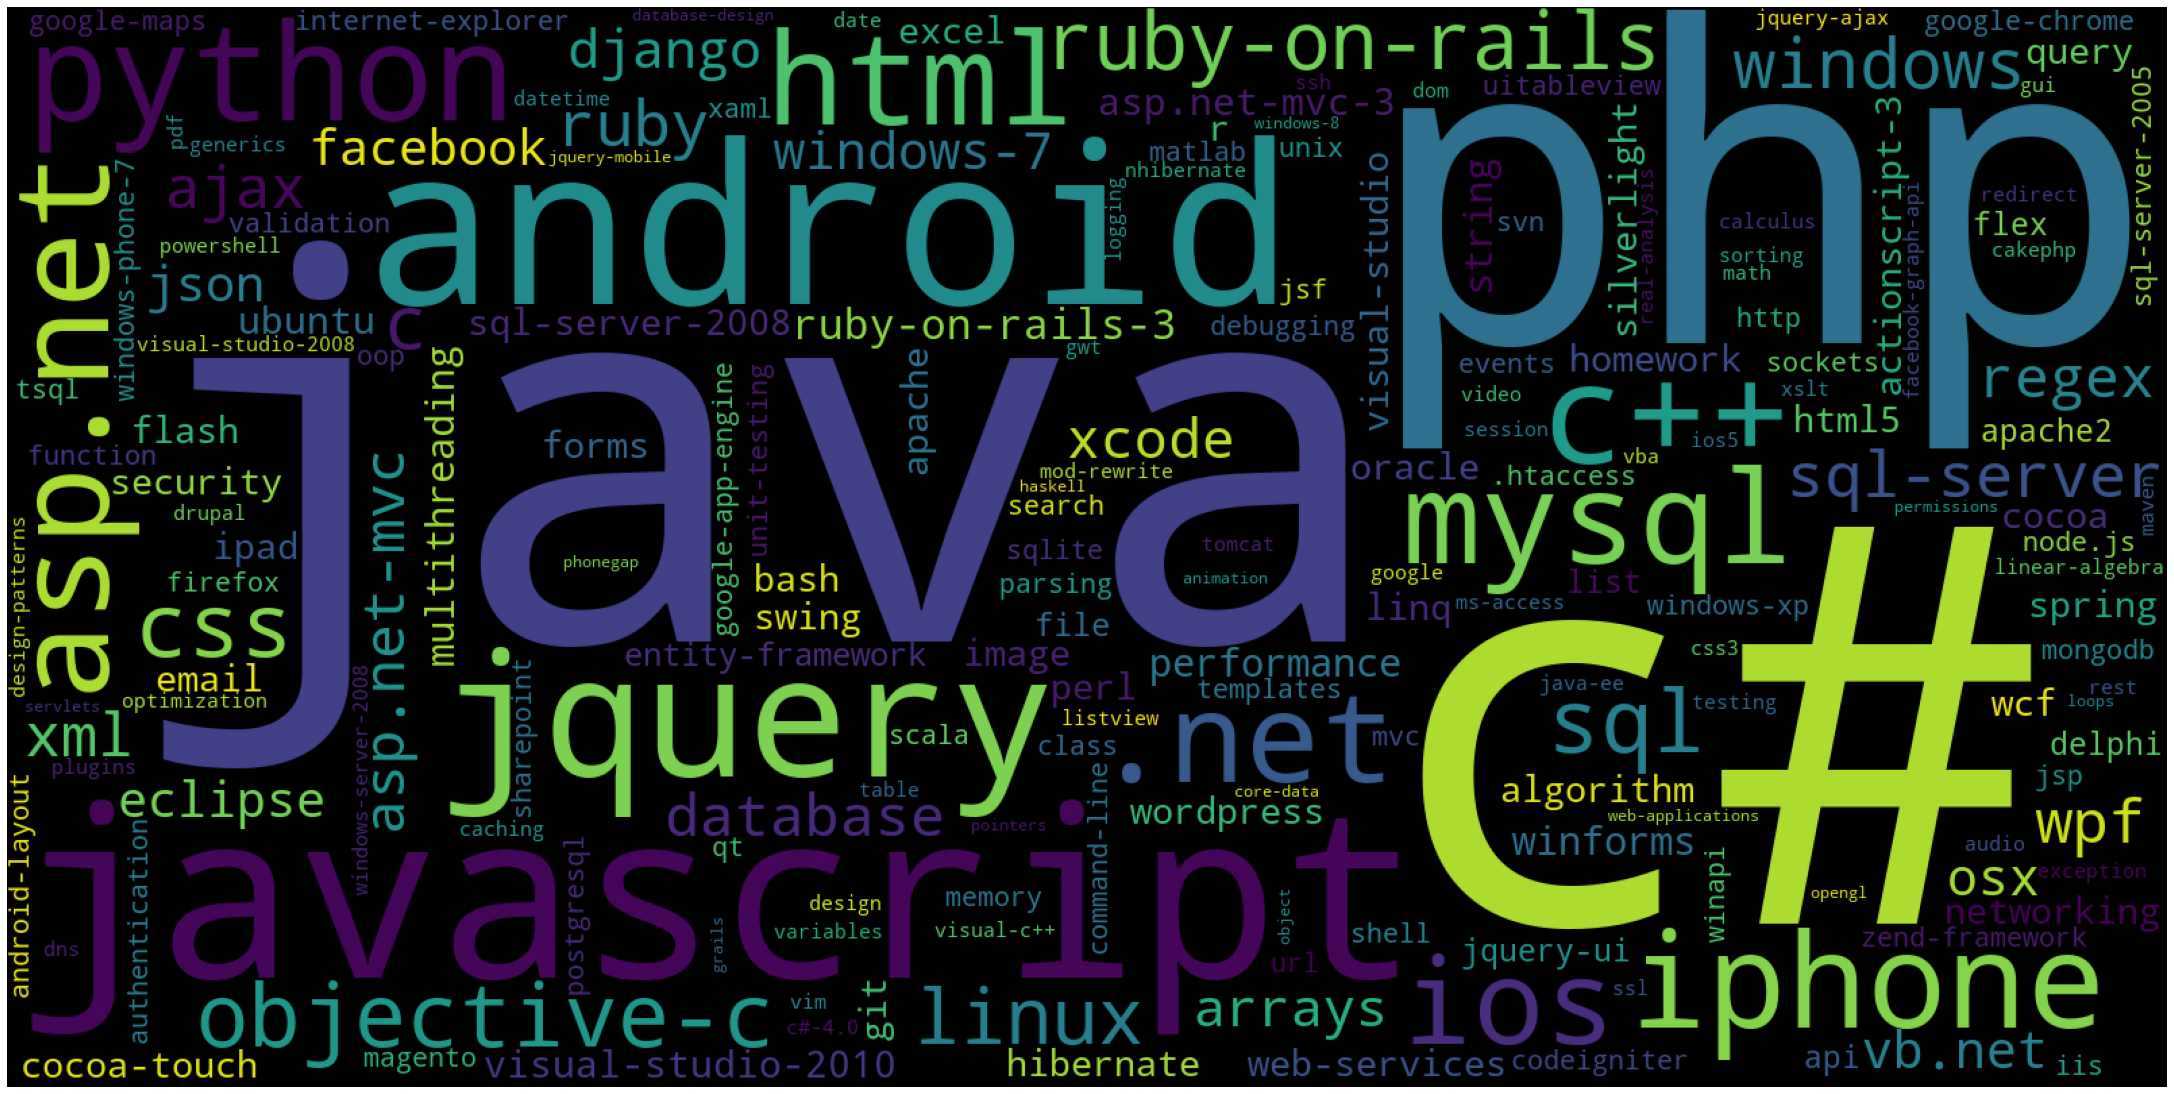

Time taken to run this cell : 0:00:05.589744


In [ ]:
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

Observations:
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

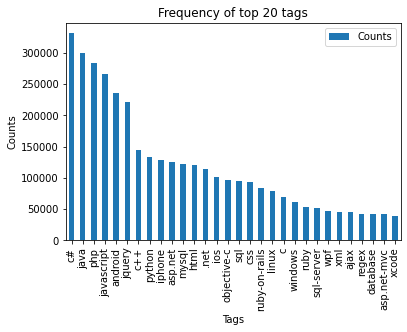

In [ ]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

**Observations:**

1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

## CLEANING & PREPROCESSING OF QUESTIONS

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [ ]:
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:39:07.870862


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1168
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:25:27.569922


In [ ]:
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('right wrong practic use statement foo foo true throughout short career far program mere student work internship notic come statement two differ way take boolean valu prefer way thing deal statement look fals use howev peopl see rais eyebrow suggest may stuck bad habit want know differ way typic way fall common trap new programm differ least notic one',)
----------------------------------------------------------------------------------------------------
('java anim import imag netbean hi want ask move import jpg imag left right bottom beginn java pleas help thank',)
----------------------------------------------------------------------------------------------------
('help sql inner join tri inner join temp tabl ni know done done complet forgot npleas advis queri tri execut fail ni think allow use tmp subqueri creat tmp msg level state line multi part identifi tmp idplay could bound',)
------------------------------------------------------------------------

In [ ]:
start = datetime.now()
con=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/StackOverflow Tag Predictor/Processed.db')
preprocessed_data  = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""",con)
con.close()
print("Time taken to count the number of rows :", datetime.now() - start)

Time taken to count the number of rows : 0:00:21.968940


In [ ]:
preprocessed_data.head()

,question,tags
0,macport gcc select error tri exec appl darwin ...,macports selection gcc
1,right wrong practic use statement foo foo true...,validation if-statement logic
2,java anim import imag netbean hi want ask move...,java animation
3,help sql inner join tri inner join temp tabl n...,sql-server inner-join
4,possibl pitfal use extens method base shorthan...,c# .net-3.5 extension-methods


## MACHINE LEARNING MODELS 

### Converting Tags to MultiLabel Problems

In [ ]:
preprocessed_data[preprocessed_data.isnull().any(axis=1)]

,question,tags
642062,handl nullobject done quit bit research best w...,None


In [ ]:
preprocessed_data.loc[preprocessed_data['tags'].isnull(),'tags'] = ''

In [ ]:
# binary = true  , means it will return binary vector
count_vectorizer=CountVectorizer(tokenizer = lambda x : str(x).split() , binary='true')

multilabel_y=count_vectorizer.fit_transform(preprocessed_data['tags'])

In [8]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [ ]:
multilabel_y.shape[1]

35388

In [ ]:
preprocessed_data.shape[0]

999997

In [ ]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

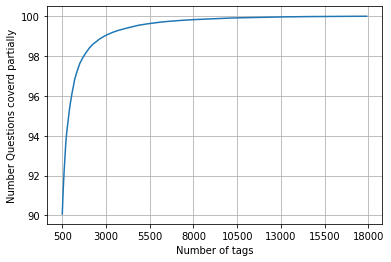

with  5500 tags we are covering  99.048 % of questions


In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [ ]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9517 out of  999997


In [ ]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35388
number of tags taken : 5500 ( 15.541991635582683 %)


### Split the Data into Test & Train

In [ ]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [ ]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799997, 5500)
Number of data points in test data : (200000, 5500)


## Featurizing of data 

### TF-IDF Featurization Vector

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,1))

In [ ]:
x_train_multilabel = vectorizer.fit_transform(x_train['question'])

In [ ]:
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:37.624874


In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (799997, 9366) Y : (799997, 5500)
Dimensions of test data X: (200000, 9366) Y: (200000, 5500)


In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

In [5]:
start = datetime.now()
con=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/StackOverflow Tag Predictor/Titlemoreweight.db')
preprocessed_data  = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed LIMIT 200000""",con)
con.close()
print("Time taken to count the number of rows :", datetime.now() - start)

Time taken to count the number of rows : 0:04:14.738980


In [6]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 200000
number of dimensions : 2


In [7]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [9]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

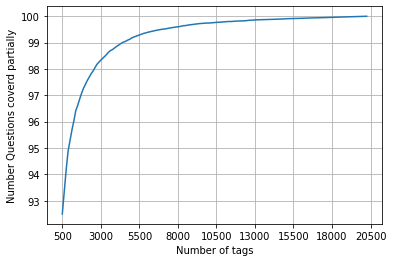

with  5500 tags we are covering  99.481 % of questions
with  500 tags we are covering  92.5 % of questions


In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [10]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 15044 out of  200000


In [11]:
train_datasize = 130000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 130000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [12]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (130000, 500)
Number of data points in test data : (70000, 500)


In [13]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000,
                             tokenizer = lambda x: str(x).split(),ngram_range=(1,4))
x_train_multilabel_bow = vectorizer.fit_transform(x_train['question'])
x_test_multilabel_bow = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:02:30.165520


In [14]:
print("Dimensions of train data X:",x_train_multilabel_bow.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel_bow.shape,"Y:",y_test.shape)

Dimensions of train data X: (130000, 100181) Y : (130000, 500)
Dimensions of test data X: (70000, 100181) Y: (70000, 500)


In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=1)
classifier.fit(x_train_multilabel_bow, y_train)
predictions = classifier.predict (x_test_multilabel_bow)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.11258571428571429
Hamming loss  0.006103285714285714
Micro-average quality numbers
Precision: 0.3424, Recall: 0.5517, F1-measure: 0.4225
Macro-average quality numbers
Precision: 0.1623, Recall: 0.3566, F1-measure: 0.2083
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     42802
           1       0.25      0.32      0.28      1764
           2       0.27      0.41      0.33       942
           3       0.24      0.28      0.26      6539
           4       0.35      0.45      0.40      2540
           5       0.50      0.58      0.54      2156
           6       0.47      0.54      0.50      1990
           7       0.13      0.21      0.16       611
           8       0.20      0.33      0.25       324
           9       0.69      0.74      0.71      2335
          10       0.27      0.43      0.33       736
          11       0.23      0.38      0.29      1199
          12       0.31      0.48      0.38       842
         

In [ ]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1',solver='liblinear'), n_jobs=1)
classifier_2.fit(x_train_multilabel_bow, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel_bow)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2359
Hamming loss  0.002942057142857143
Micro-average quality numbers
Precision: 0.6777, Recall: 0.5207, F1-measure: 0.5889
Macro-average quality numbers
Precision: 0.4122, Recall: 0.3021, F1-measure: 0.3397
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     42802
           1       0.42      0.26      0.32      1764
           2       0.56      0.38      0.46       942
           3       0.34      0.19      0.25      6539
           4       0.48      0.41      0.45      2540
           5       0.65      0.54      0.59      2156
           6       0.66      0.50      0.57      1990
           7       0.31      0.17      0.22       611
           8       0.55      0.24      0.34       324
           9       0.76      0.78      0.77      2335
          10       0.48      0.40      0.44       736
          11       0.40      0.29      0.34      1199
          12       0.55      0.40      0.46       842
          13       0.5

### LINEAR SVM 

In [ ]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier


LinearSVM = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l2',random_state=None, class_weight=None), n_jobs=1)
LinearSVM.fit(x_train_multilabel_bow, y_train)
predictions_svm = LinearSVM.predict(x_test_multilabel_bow)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_svm))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_svm))


precision = precision_score(y_test, predictions_svm, average='micro')
recall = recall_score(y_test, predictions_svm, average='micro')
f1 = f1_score(y_test, predictions_svm, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_svm, average='macro')
recall = recall_score(y_test, predictions_svm, average='macro')
f1 = f1_score(y_test, predictions_svm, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_svm))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.2384
Hamming loss  0.002897085714285714
Micro-average quality numbers
Precision: 0.7029, Recall: 0.4923, F1-measure: 0.5790
Macro-average quality numbers
Precision: 0.4318, Recall: 0.2714, F1-measure: 0.3184
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     42802
           1       0.36      0.23      0.28      1764
           2       0.55      0.32      0.40       942
           3       0.36      0.17      0.23      6539
           4       0.46      0.37      0.41      2540
           5       0.64      0.53      0.58      2156
           6       0.64      0.49      0.56      1990
           7       0.29      0.18      0.22       611
           8       0.43      0.25      0.32       324
           9       0.76      0.79      0.78      2335
          10       0.44      0.38      0.41       736
          11       0.37      0.25      0.29      1199
          12       0.49      0.36      0.42       842
          13       0.5

## LOGISTIC REGRESSION FOR HYPER PARAMETER TUNING

In [15]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

start = datetime.now()

grid_params = [{ 'estimator__C' : [10**x for x in range(-4,3)]}]
logistic_regression = OneVsRestClassifier(LogisticRegression(penalty='l1',solver='liblinear'))
clf=GridSearchCV(logistic_regression,grid_params,scoring='f1_micro',cv=3)
clf.fit(x_train_multilabel_bow, y_train)
predictions_2 = clf.predict(x_test_multilabel_bow)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.23587142857142857
Hamming loss  0.0029417714285714285
Micro-average quality numbers
Precision: 0.6778, Recall: 0.5207, F1-measure: 0.5890
Macro-average quality numbers
Precision: 0.4123, Recall: 0.3021, F1-measure: 0.3397
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     42802
           1       0.42      0.26      0.32      1764
           2       0.56      0.38      0.46       942
           3       0.34      0.19      0.25      6539
           4       0.48      0.41      0.45      2540
           5       0.65      0.54      0.59      2156
           6       0.66      0.50      0.57      1990
           7       0.31      0.17      0.22       611
           8       0.55      0.24      0.34       324
           9       0.76      0.78      0.77      2335
          10       0.48      0.40      0.44       736
          11       0.40      0.29      0.34      1199
          12       0.55      0.40      0.46       842
        

### CONCLUSION USING PRETTY TABLE

In [16]:
pip install -U PTable

  Created wheel for PTable: filename=PTable-0.9.2-cp36-none-any.whl size=22908 sha256=411947626798f9652c176229bca92fe9287a3e91ed971cdbe826fcc8605361a1
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
Successfully built PTable


In [17]:
from prettytable import PrettyTable
x= PrettyTable()
x.title = "TF-IDF Featurization"
x.field_names = ["Algorithm" , "Macro F1 Score Precision", "Micro F1 Score", "Hamming Loss"]
x.add_row(["Logistic Regression with OneVsRest",0.5473,0.7216,0.002708])
print(x)
y= PrettyTable()
y.add_row(["Logistic Regression with OneVsRest",0.4122,0.6777,0.002942])
y.add_row(["Linear SVM with OneVsRest",0.4318,0.7029,0.00289])
y.add_row(["Logistic Regression for Hyperparameter Tuning GridSearch",0.4123,0.6778,0.00290])
y.title = "CountVectorizer BIGRAM"
y.field_names = ["Algorithm" , "Macro F1 Score Precision", "Micro F1 Score", "Hamming Loss"]
print(y)

+-----------------------------------------------------------------------------------------------+
|                                      TF-IDF Featurization                                     |
+------------------------------------+--------------------------+----------------+--------------+
|             Algorithm              | Macro F1 Score Precision | Micro F1 Score | Hamming Loss |
+------------------------------------+--------------------------+----------------+--------------+
| Logistic Regression with OneVsRest |          0.5473          |     0.7216     |   0.002708   |
+------------------------------------+--------------------------+----------------+--------------+
+---------------------------------------------------------------------------------------------------------------------+
|                                                CountVectorizer BIGRAM                                               |
+----------------------------------------------------------+--------------

CONCLUSION : LOGISTIC REGRESSION WITH ONEVSREST HAVE GOOD PRECISION : 0.6777 AS MICRO F1 SCORE